In [1]:
import numpy as np
import pandas as pd

import gensim
from gensim.models import Word2Vec
LabeledSentence = gensim.models.doc2vec.LabeledSentence 

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('cleaned_data.csv', encoding='utf-8')

In [3]:
# data preprocessing: clear and clean the data from nonsense letters and words

import re

lst= ['#','%','@','*', ':']
pat1 = r'@[A-Za-z0-9]+'

def tokenize(tweet):
    num = re.compile(r'[0-9]+')
    tweet = re.sub(num, "", str(tweet))
    tokens = tokenizer.tokenize(str(tweet))
    for i in lst:
        if i in tokens:
            tokens.remove(i)
    return tokens
                                
df['tokens'] = df['text'].apply(tokenize)

In [4]:
df.head()

,Unnamed: 0,text,label,tokens
0,0,RT : خالد السليمان : لـ # ولي_العهد الأمير # م...,0,"[RT, خالد, السليمان, :, لـ, ولي_العهد, الأمير,..."
1,1,RT : المختصر .. العمل في الشأن الثقافي ليس فقط...,0,"[RT, المختصر, .., العمل, في, الشأن, الثقافي, ل..."
2,2,# الإسكان تطلق منصة جديدة يمكنك من خلالها الحص...,2,"[الإسكان, تطلق, منصة, جديدة, يمكنك, من, خلالها..."
3,3,# وزير_المالية : تم تخصيص 70 ألف أرض سكنية وتخ...,2,"[وزير_المالية, تم, تخصيص, ألف, أرض, سكنية, وتخ..."
4,4,تملك السعودين للمنازل يقفز 50 % والتصاعد مستمر...,2,"[تملك, السعودين, للمنازل, يقفز, والتصاعد, مستم..."


In [5]:
# Data segmentation, 
X_train, X_test, y_train, y_test = train_test_split(df['tokens'], df['label'], test_size=0.33, random_state=42)

In [6]:
X_train[0]

['RT',
 'خالد',
 'السليمان',
 ':',
 'لـ',
 'ولي_العهد',
 'الأمير',
 '#',
 'محمد_بن_سلمان',
 'الدور',
 'الأبرز',
 'في',
 'أرتفاع',
 'نسبة',
 'التملك',
 'لـ',
 '٥٠',
 '٪',
 'بعد',
 'ما',
 'كانت',
 'شبه',
 'ثابته',
 'عند',
 '٤٧',
 '٪',
 'ك',
 '…']

## Use the trained Word2Vec model 

In [7]:
w2v = Word2Vec.load('cbow.bin')

In [8]:
# Test word and sees it similarity
w2v.most_similar('العهد')

/home/mgalalen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('ولي', 0.9438014030456543),
 ('عهده', 0.8968819975852966),
 ('عهدنا', 0.88190758228302),
 ('عهد', 0.8595527410507202),
 ('الامير', 0.8186361193656921),
 ('سيدي', 0.8035902976989746),
 ('لولي', 0.794856071472168),
 ('خادم', 0.7939093112945557),
 ('الشاب', 0.7750820517539978),
 ('حكم', 0.768715500831604)]

In [9]:
pretrained_weights = w2v.wv.syn0

/home/mgalalen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [10]:
vocab_size, emdedding_size = pretrained_weights.shape

In [11]:
def word2idx(word):
    return w2v.wv.vocab[word].index

def idx2word(idx):
    return w2v.wv.index2word[idx]

In [12]:
# To find importance of the word with respect to the corpus.
# see: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

print('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 4476


In [13]:
# convert tokens to vector of words

def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
            continue
    if count != 0:
        vec /= count
    return vec

In [14]:
# Scale data and build words vector
from sklearn.preprocessing import scale

n_dim = 200

train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x, X_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x, X_test))])
test_vecs_w2v = scale(test_vecs_w2v)


0it [00:00, ?it/s]/home/mgalalen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
21482it [00:05, 3941.56it/s]
10581it [00:02, 4308.13it/s]


In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Activation, Flatten, Bidirectional
from keras.utils import to_categorical
import keras_metrics

# convent labels to categorical classes
cy_train = to_categorical(y_train)
cy_test = to_categorical(y_test)

Using TensorFlow backend.


In [16]:
train_vecs_w2v.shape

(21482, 200)

In [17]:
from keras import backend as K


# calculate f score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



# LSTM

In [23]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='sigmoid'))
lstm_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy', 
                       keras_metrics.precision(),
                      keras_metrics.recall(),
                      f1])

lstm_his = lstm_model.fit(train_vecs_w2v.reshape((train_vecs_w2v.shape[0],1,200)), cy_train, epochs=10, batch_size=32, verbose=2)
lstm_model.summary()

Epoch 1/10
 - 4s - loss: 0.1796 - acc: 0.9394 - precision: 0.9496 - recall: 0.8956 - f1: 0.9192
Epoch 2/10
 - 4s - loss: 0.0913 - acc: 0.9651 - precision: 0.9931 - recall: 0.8221 - f1: 0.8980
Epoch 3/10
 - 3s - loss: 0.0765 - acc: 0.9717 - precision: 0.9968 - recall: 0.7715 - f1: 0.8677
Epoch 4/10
 - 3s - loss: 0.0701 - acc: 0.9725 - precision: 0.9986 - recall: 0.7283 - f1: 0.8395
Epoch 5/10
 - 3s - loss: 0.0616 - acc: 0.9774 - precision: 0.9989 - recall: 0.6980 - f1: 0.8190
Epoch 6/10
 - 3s - loss: 0.0592 - acc: 0.9773 - precision: 0.9992 - recall: 0.6802 - f1: 0.8064
Epoch 7/10
 - 2s - loss: 0.0538 - acc: 0.9798 - precision: 0.9997 - recall: 0.6505 - f1: 0.7848
Epoch 8/10
 - 2s - loss: 0.0526 - acc: 0.9793 - precision: 0.9997 - recall: 0.6410 - f1: 0.7776
Epoch 9/10
 - 3s - loss: 0.0488 - acc: 0.9815 - precision: 0.9996 - recall: 0.6481 - f1: 0.7831
Epoch 10/10
 - 3s - loss: 0.0484 - acc: 0.9813 - precision: 0.9998 - recall: 0.6406 - f1: 0.7775
_______________________________________

In [24]:
score = lstm_model.evaluate(test_vecs_w2v.reshape((test_vecs_w2v.shape[0], 1, test_vecs_w2v.shape[1])), cy_test, batch_size=128, verbose=2)
print('LSTM model acuracy: {}'.format(score[1]*100))

LSTM model acuracy: 97.95860504903524


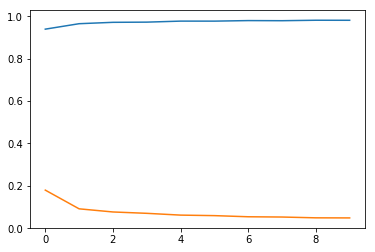

In [25]:
import matplotlib.pyplot as plt
plt.plot(lstm_his.history['acc'])
plt.plot(lstm_his.history['loss'])
plt.show()

In [28]:
# saving the model to the disk
# use should install HDF5 or h5py to save the model
# see: https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

# lstm_model.save('lstm_model.h5')

# Bidirectional LSTM

In [26]:
model = Sequential()
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                      keras_metrics.precision(),
                      keras_metrics.recall(),
                      f1])
history = model.fit(train_vecs_w2v.reshape((train_vecs_w2v.shape[0],1,200)),
                    cy_train,
                    epochs=10,
                    batch_size=32,
                    verbose=2)
model.summary()

Epoch 1/10
 - 7s - loss: 0.1471 - acc: 0.9504 - precision: 0.9683 - recall: 0.8446 - f1: 0.8985
Epoch 2/10
 - 5s - loss: 0.0774 - acc: 0.9710 - precision: 0.9970 - recall: 0.7328 - f1: 0.8418
Epoch 3/10
 - 4s - loss: 0.0661 - acc: 0.9756 - precision: 0.9983 - recall: 0.6695 - f1: 0.7982
Epoch 4/10
 - 4s - loss: 0.0580 - acc: 0.9776 - precision: 0.9993 - recall: 0.6362 - f1: 0.7736
Epoch 5/10
 - 4s - loss: 0.0528 - acc: 0.9798 - precision: 0.9994 - recall: 0.6208 - f1: 0.7623
Epoch 6/10
 - 4s - loss: 0.0462 - acc: 0.9820 - precision: 0.9999 - recall: 0.6099 - f1: 0.7537
Epoch 7/10
 - 4s - loss: 0.0450 - acc: 0.9825 - precision: 0.9997 - recall: 0.6082 - f1: 0.7525
Epoch 8/10
 - 4s - loss: 0.0399 - acc: 0.9847 - precision: 0.9999 - recall: 0.6217 - f1: 0.7633
Epoch 9/10
 - 4s - loss: 0.0384 - acc: 0.9855 - precision: 0.9998 - recall: 0.6181 - f1: 0.7600
Epoch 10/10
 - 5s - loss: 0.0356 - acc: 0.9857 - precision: 0.9999 - recall: 0.6270 - f1: 0.7675
_______________________________________

In [27]:
# The accuracy of the model
score = model.evaluate(test_vecs_w2v.reshape((test_vecs_w2v.shape[0], 1, test_vecs_w2v.shape[1])), cy_test, batch_size=128, verbose=2)
print('Bidirectional model acuracy: {}'.format(score[1]*100))

Bidirectional model acuracy: 98.3082884426728


In [29]:
# lstm_model.save('bilstm_model.h5')

In [ ]:
# Loading the model
# from keras.models import load_model
# loaded_model = load_model("")